In [ ]:
# default_exp samplers

# Samplers

> Collection of different samplers for sampling logical failure rates from quantum error correction circuits

In [ ]:
# hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import qsam.math as math
from qsam.circuit import partition
from qsam.simulators.chp import CHP
from qsam.fault_generators import Depolar

import numpy as np
import itertools as it

ModuleNotFoundError: No module named 'qsam'

In [ ]:
#export
ONE_QUBIT_GATES = {'H', 'X', 'Z'}
TWO_QUBIT_GATES = {'CNOT'}

GATE_GROUPS = {'p': ONE_QUBIT_GATES | TWO_QUBIT_GATES,
               'p1': ONE_QUBIT_GATES,
               'p2': TWO_QUBIT_GATES }

In [ ]:
#export
class Sampler:
    """Sampler base class"""
    
    def __init__(self, circuit, err_params):
        self.circuit = circuit
        self.n_qubits = circuit.n_qubits
        self.partitions = [partition(circuit, GATE_GROUPS[g]) for g in err_params.keys()]
        self.p_phys_mat = np.vstack(list(err_params.values())).T # p_phy_range x partitions
        self.fault_gen = Depolar(n_ticks=len(circuit))

    def _sample(self, params):
        sim = CHP(self.n_qubits)
        fault_circuit = self.fault_gen.generate(self.partitions, params, type(self).__name__)
        return sim.run(self.circuit, fault_circuit)

    def _check_logical_failure(self, msmt):
        return 1 if msmt.items() <= self.circuit.failures.items() else 0

In [ ]:
#export
class DirectSampler(Sampler):
    """Direct Monte Carlo sampler"""

    def run(self, n_samples=100, var=math.Wilson_var):
        fail_cnts = np.zeros((self.p_phys_mat.shape[0])) # one fail counter per p_phys

        for i, p_phys in enumerate(self.p_phys_mat):
            for _ in range(n_samples):
                msmt = self._sample(p_phys)
                fail_cnts[i] += self._check_logical_failure(msmt)

        p_L = fail_cnts / n_samples
        std = np.sqrt( var(p_L, n_samples) )
        return p_L, std

In [ ]:
#hide
#export
def uniform_select(counts, *args, **kwargs):
    """Return index of least sampled SS"""
    return np.argmin(counts)

def ERV_select(counts, fail_counts, ss_factors=1, var=math.Wilson_var, *args, **kwargs):
    """Return index of SS which yields maximum ERV"""

    p = fail_counts / counts # list of SS failure rates
    v = var(p, counts) # list of variances

    # prospective failure rates
    p_p = (fail_counts+1) / (counts+1) # next msmt yields +1 (i.e. 1)
    p_m = fail_counts / (counts+1) # next msmt yields -1 (i.e. 0)

    # prospective variances
    v_p = var(p_p, counts+1) 
    v_m = var(p_m, counts+1)

    # expectation value of prospective variances
    v_prop = p*v_p + (1-p)*v_m 

    # maximize difference (scaled by occurance prob)
    delta = ss_factors**2 * (v - v_prop)
    return np.argmax(delta)

In [ ]:
#hide
#export
def calc_w_max(p_max, delta_max, n_partition_elems):
    """Calculate weight cutoff at p_max for delta_max."""
    
    delta = 1
    for w_max in range(n_partition_elems+1):
        delta -= math.binom(w_max, n_partition_elems, p_max)
        if delta < delta_max: 
            break
    return w_max

# def calc_partition_weight_vecs(p_maxs, delta_maxs, partitions):
#     """Find w_max vector for delta_max at p_max and 
#     return all partition weight vectors up to w_max_vec"""
    
#     assert len(p_maxs) == len(delta_maxs) == len(partitions)
#     w_max_vec = [calc_w_max(p_max,d_max,len(partition)) for p_max,d_max,partition in zip(p_maxs,delta_maxs,partitions)]
#     w_vecs = list(it.product( *[list(range(w_max+1)) for w_max in w_max_vec] ))
#     return w_vecs

def calc_partition_weight_vecs(p_max, delta_max, partitions):
    # Find w_max vector for delta_max at p_max
    assert len(p_max) == len(delta_max) == len(partitions)
    w_cutoff = np.zeros_like(p_max, dtype=int)
    for i in range(len(w_cutoff)):
        w_cutoff[i] = calc_w_max(p_max[i], delta_max[i], len(partitions[i]))
    # Generate weight vectors (combis of all ws up to each w_max per partition)
    w_vecs = list(it.product( *[list(range(w_cutoff_i+1)) for w_cutoff_i in w_cutoff] ))
    return w_vecs

def calc_subset_occurances(partitions, partition_weight_vecs, p_phys_mat):
    """Calculate 3D tensor of binom. coefficients for each partition"""
    
    n_partition_elems = np.array([len(p) for p in partitions])
    Aws = np.array([math.binom(w_vec, n_partition_elems, p_phys_mat) for w_vec in partition_weight_vecs])
    Aws = np.product(Aws, axis=-1) # get list of Aw for each partition SS combination
    return Aws

def calc_statistics(Aws, pws, n_samples, var=math.Wilson_var):
    """Calculate upper and lower bounds on logical failure rate and standard deviation"""
    
    p_L_low = np.sum(Aws * pws, axis=0)
    p_L_up = p_L_low + 1 - np.sum(Aws, axis=0)
    std = math.std_sum(Aws, pws, n_samples, var)
    return p_L_up, p_L_low, std

In [ ]:
#export
class SubsetSampler(Sampler):
    """Monte Carlo subset sampler"""
    
    def __init__(self, circuit, err_params, subset_select_fn=uniform_select):
        self.subset_select_fn = subset_select_fn
        super().__init__(circuit, err_params)
        
    def _monte_carlo(self, w_vecs, n_samples):
        """Generate 1D list of subset failure rates per weight vector combi"""
        cnts      = np.zeros((len(w_vecs))) + 1 # one virtual sample to avoid div0
        fail_cnts = np.zeros((len(w_vecs))) 

        for i in range(n_samples):
            idx = self.subset_select_fn(cnts, fail_cnts)
            w_vec = w_vecs[idx]
            msmt = self._sample(w_vec)
            fail_cnts[idx] += self._check_logical_failure(msmt)
            cnts[idx] += 1
        return fail_cnts, cnts - 1 # remove virtual sample
            
    def run(self, p_max, delta_max, n_samples=20, var=math.Wilson_var):

        w_vecs = calc_partition_weight_vecs(p_max, delta_max, self.partitions)
        fail_cnts, cnts = self._monte_carlo(w_vecs, n_samples)

        pws = (fail_cnts / cnts)[:,None]
        Aws = calc_subset_occurances(self.partitions, w_vecs, self.p_phys_mat) # TODO: ERV, GIVE LARGEST Aw.

        return calc_statistics(Aws, pws, n_samples, var)

Let's see how the samplers work. First we create some circuit to sample from. Let's choose a simple GHZ preparation flag circuit. This circuit produces the four-qubit GHZ state $|GHZ\rangle=\frac{1}{\sqrt{2}}(|0000\rangle+|1111\rangle)$ on qubits 0-3. The fifth qubit (qubit no. 4) is the flag which we measure to be either +1 if our prepared GHZ-state is error-free or if there is only a weight-1 error on the state (Note, we use **error** instead of **fault** to highlight that that we are talking about the **final faulty state**). If the flag measurement yield -1 (i.e. 0 in binary logic) we know that an error of weight larger than 1 occured on our final state, i.e. $|GHZ\rangle\rightarrow E_w|GHZ\rangle$, where $w\gt 1$ is the error-weight. Only these events we want to count as logical errors. Thus, let us first define the circuit and the physical error probabilities at which we want to sample logical error rates:

In [ ]:
from qsam.circuit import Circuit
import numpy as np

ghz = Circuit([ {"H": {0}},
                {"CNOT": {(0,1)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(2,3)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(0,4)}},
                {"measure": {4}}   ])

ghz.failures[((6,4),)] = '1' # define which measurement is a failure for this circuit

p = np.logspace(-3,0,10)
err_params = {'p': p}

Next, we create a sampler object and run it for a specified number of samples. Let's start with the `DirectSampler`:

In [ ]:
#slow
sam = DirectSampler(ghz, err_params)
p_L, std = sam.run(n_samples=1000)

Similarly, we can do the same sampling using the `SubsetSampler`. For this, we need to provide the `p_max` and `delta_max` parameters additionally by which the maximum fault-weight subsets are determined we wish to include in the our sampling. We also note that the `run` method in this case gives us an upper and a lower bound on the logical error rate instead of a single `p_L` as before. `delta_max` is the distance between these bounds at the `p_max` value. So, for large `p_max`, larger fault-weight subsets become relevant and in turn `delta_max` would increase if we didn't include those. 

In [ ]:
#slow
sam = SubsetSampler(ghz, err_params)
p_L_low, p_L_up, ss_std = sam.run(p_max=[0.1], delta_max=[0.1], n_samples=1000)

Let's plot and compare the two:

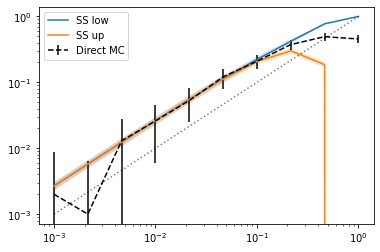

In [ ]:
import matplotlib.pyplot as plt

plt.errorbar(p, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(p, p_L_low, label="SS low")
plt.fill_between(p, p_L_low-ss_std, p_L_low+ss_std, alpha=0.2)
plt.plot(p, p_L_up, label="SS up")
plt.fill_between(p, p_L_up-ss_std, p_L_up+ss_std, alpha=0.2)

plt.plot(p, p, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend()

# Multi-parameter error models
Similarly, for a multi-parameter noise model all we have to do is specify the physical error rates for corresponding partitions and pass it to the sampler. Note that for now only two partitions are implemented (one for one-qubit gates and one for two-qubit gates).

In [ ]:
#slow
p1 = np.logspace(-3,0,10)
p2 = 0.5 * p1
err_params = {'p1': p1, 'p2': p2}
sam = DirectSampler(ghz, err_params)

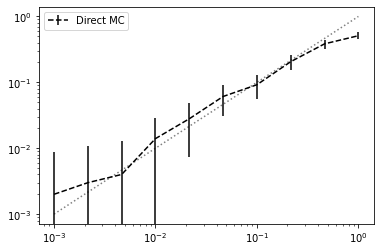

In [ ]:
p_L, std = sam.run(n_samples=1000)
plt.errorbar(p, p_L, fmt='--', c="black", yerr=std, label="Direct MC")
plt.plot(p, p, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend()

# Subset sampling helper functions
> Collection functions to support subset sampling.

First, let's talk about how to decide which subset to sample from during subset sampling. The simplest strategy would be to always select the subset which was sampled least in order to sample uniformly from every subset:

In [ ]:
show_doc(uniform_select)

<h4 id="uniform_select" class="doc_header"><code>uniform_select</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>uniform_select</code>(**`counts`**, **\*`args`**, **\*\*`kwargs`**)

Return index of least sampled SS

Alternatively, we can make a decision which is more informed on a) the occurance probability of subsets (i.e. the binomial weights $A_w$) and the current as well as prospective variances for sampling respective subsets. Selecting the weight for which the difference scaled by $A_w^2$ yields a maximum is the best next subset weight we can choose in order to reduce the global variance the most. This method is termed Expected Reduction of Variance (ERV):

In [ ]:
show_doc(ERV_select)

<h4 id="ERV_select" class="doc_header"><code>ERV_select</code><a href="__main__.py#L7" class="source_link" style="float:right">[source]</a></h4>

> <code>ERV_select</code>(**`counts`**, **`fail_counts`**, **`ss_factors`**=*`1`*, **`var`**=*`Wilson_var`*, **\*`args`**, **\*\*`kwargs`**)

Return index of SS which yields maximum ERV

We can compare the results of using the two methods.

In [ ]:
show_doc(calc_w_max)

<h4 id="calc_w_max" class="doc_header"><code>calc_w_max</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>calc_w_max</code>(**`p_max`**, **`delta_max`**, **`n_partition_elems`**)

Calculate weight cutoff at p_max for delta_max.

In [ ]:
show_doc(calc_partition_weight_vecs)

<h4 id="calc_partition_weight_vecs" class="doc_header"><code>calc_partition_weight_vecs</code><a href="__main__.py#L22" class="source_link" style="float:right">[source]</a></h4>

> <code>calc_partition_weight_vecs</code>(**`p_max`**, **`delta_max`**, **`partitions`**)



In [ ]:
show_doc(calc_subset_occurances)

<h4 id="calc_subset_occurances" class="doc_header"><code>calc_subset_occurances</code><a href="__main__.py#L32" class="source_link" style="float:right">[source]</a></h4>

> <code>calc_subset_occurances</code>(**`partitions`**, **`partition_weight_vecs`**, **`p_phys_mat`**)

Calculate 3D tensor of binom. coefficients for each partition

In [ ]:
show_doc(calc_statistics)

<h4 id="calc_statistics" class="doc_header"><code>calc_statistics</code><a href="__main__.py#L40" class="source_link" style="float:right">[source]</a></h4>

> <code>calc_statistics</code>(**`Aws`**, **`pws`**, **`n_samples`**, **`var`**=*`Wilson_var`*)

Calculate upper and lower bounds on logical failure rate and standard deviation